# UM-Bridge with QMCPy

Using QMCPy to evaluate the [UM-Bridge Cantilever Beam Function](https://um-bridge-benchmarks.readthedocs.io/en/docs/forward-benchmarks/muq-beam-propagation.html) and approximate the expectation with respect to a uniform random variable. 

## Imports

In [2]:
import umbridge
import numpy as np
import time
#import docker

#the module needs to be local if any changes have been made locally
#uncomment line below to make local qmcpy the import (only need to be done once per session and can be commented out
#import sys
#sys.path.insert(0, '../../../../..') #may need to be changed to find correct path to QMCSoftware folder

#prints paths available on local system
#for p in sys.path:
#    print(p)

import qmcpy as qp #non local module import
#from QMCSoftware import qmcpy as qp #local module import

## Start Docker Container

See the [UM-Bridge Documentation](https://um-bridge-benchmarks.readthedocs.io/en/docs/index.html) for image options. 

In [238]:
!docker rm -f muqbp_new
!docker run --name muqbp_new -it -d -p 4242:4242 linusseelinger/model-muq-beam:latest
#!docker run --name muqbp_new -d -p 4242:4242 my-build
#https://stackoverflow.com/questions/43099116/error-the-input-device-is-not-a-tty
#running locally

muqbp_new
df496f568915fe667b657e7f1f6aa7f7b281e55a4f27e59d751077be6ee82419


## Problem Setup

Initialize a QMCPy sampler and distribution.

In [228]:
sampler_d = 3
sampler = qp.DigitalNetB2(dimension = sampler_d,seed=7) # DISCRETE DISTRIBUTION, default = 3
distribution = qp.Uniform(sampler,lower_bound=1,upper_bound=1.1) # TRUE MEASURE

Initialize a UM-Bridge model and wrap it into a QMCPy compatible Integrand

In [229]:
model = umbridge.HTTPModel('http://localhost:4242', 'forward')
output_dimension = 31 #can't find where 31 is in um-bridge so I'm setting it here
beam_length = 1
umbridge_config = {}
"""DEBUG
print(umbridge_config)
print(model.get_input_sizes(umbridge_config))
print(model.get_output_sizes(umbridge_config))
print(distribution.d)
"""

import math
from sklearn import gaussian_process as gp
kernel = gp.kernels.Matern(length_scale = 0.5, nu=2.5)
#nu controls smoothness, most efficient when in [0.5, 1.5, 2.5, inf]
#0.5 = absolute exponential, 1.5 = once differentiable, 2.5 = twice, ~inf = RBF
#length_scale controls "peakiness"/frequency, or correlation between points farther from each other

def lump(t):
    """ Model 1: fill with ones """
    tnp = np.array(t[0])
    tnewnp = np.ones(output_dimension)
    tnewnp[:len(tnp)] = tnp
    #print(tnewnp.tolist())
    return [tnewnp.tolist()]

def lump_2(t):
    """ Model 2: duplicating values """
    tnp = np.array(t[0])
    tnewnp = np.ones(output_dimension)
    if len(tnp) < output_dimension:
        root = output_dimension // len(tnp)
        for i in range(root + output_dimension % len(tnp)):
            tnewnp[i] = tnp[0]
        #len(tnp) * root + output_dimension % len(tnp) = len(tnp)
        for j in range(1, len(tnp)):
            for i in range(j * root + output_dimension % len(tnp), (j+1) * root + output_dimension % len(tnp)):
                tnewnp[i] = tnp[j]
    #print(tnewnp.tolist())
    return [tnewnp.tolist()]

E_variance = 0.01
x_values = np.arange(float(output_dimension)) * beam_length/float(output_dimension - 1)
def E_generator(*args):
    """Model 3: approximating/smushing continuous by returning distribution w/ multivariate, 
    Gaussian and Matern kernel"""
    tnp = np.array([x_values]).T
    #print(tnp)
    covariances = kernel.__call__(tnp) #takes array of size (# samples) x (# data points)
    #print(covariances)
    average = np.full(output_dimension, (distribution.upper_bound + distribution.lower_bound) / 2)
    #print(average)
    sampler_out = sampler.spawn(1, [output_dimension])[0] #new version of sampler with 31 dimensions
    return qp.Gaussian(sampler_out, average, E_variance * covariances, decomp_type = "Cholesky"), sampler_out

weight_decay = 6
dist_counter = 0
def E_generator_2(t):
    """Model 4: Karhunen-Loeve approximation using Chebyshev polynomials"""
    tnp = np.array(t[0])
    tnewnp = np.zeros(output_dimension) #Y(t) = (X_1 ... X_d) W (\phi_1(t) ... \phi_d(t))^T
    d = sampler_d #input dimension

    for j in range(output_dimension): #t = x_values[j]
        X = tnp #uniform iid from "distribution" sampled d times
        W = np.zeros((d, d))
        phi = np.zeros(d)
        for i in range(1, d+1):
            W[i-1][i-1] = 1.0 / (i ** weight_decay)
            phi[i-1] = math.cos(i * x_values[j]) #Chebyshev polynomials
        phi = np.array([phi]).T #transpose
        tnewnp[j] = np.matmul(np.matmul(X, W), phi)
    #print(tnewnp.tolist())
    return [tnewnp.tolist()]

#distribution_mul, sampler = E_generator() 
# ^ comment out if you don't want multivariate w/ Matern covariance (and set tf_input_to_umbridge_input = identity)
integrand = qp.UMBridgeWrapper(distribution, model, umbridge_config, parallel=False, tf_input_to_umbridge_input = E_generator_2) # INTEGRAND

In [225]:
 #debug
from sklearn import datasets as ds
"""
X, y = ds.load_iris(return_X_y=True)
print(X)
print(y)
kernel.__call__(X)
"""
#kernel.__call__([[1.05], [1.02], [1.06], [1.04]])
#E_generator([np.arange(31.0) * beam_length/31.0])
#distribution.gen_samples(1)[0]
#np.matmul([3, 2, 4], [[1], [2], [1]])
E_generator_2([[1.06, 1.05, 1.04]])

[[1.0778328617969821,
  1.0772004554838255,
  1.0753041238730268,
  1.0721465267928894,
  1.0677320901093288,
  1.0620669949927954,
  1.0551591629692758,
  1.0470182368319592,
  1.037655557511025,
  1.0270841370191108,
  1.015318627609232,
  1.0023752873000733,
  0.9882719419405496,
  0.973027944001176,
  0.9566641282940364,
  0.939202764835829,
  0.9206675090795753,
  0.9010833497499744,
  0.8804765545250538,
  0.8588746138126451,
  0.836306182874272,
  0.8128010225512823,
  0.788389938848464,
  0.7631047216290222,
  0.7369780826716282,
  0.7100435933354131,
  0.6823356220722648,
  0.6538892720177213,
  0.6247403188822024,
  0.59492514935341,
  0.5644807002085526]]

## Model Evaluation

In [230]:
start_time = time.time()
x = sampler(16) # same as sampler.gen_samples(1024)
#as sample size gets larger, since beams are i.i.d, Y should resemble a Gaussian process by the CLT
print(x.shape) #prints (# of beams, input)

y = integrand.f(x)
print(y.shape) #prints (# of beams, output)
print(type(y))
print(y.dtype)
print(y)

#time in seconds
end_time = time.time()
print(end_time - start_time)

(16, 3)
(16, 31)
<class 'numpy.ndarray'>
float64
[[    0.            72.18808031   279.34135007   612.41370675
   1062.71452135  1621.89838665  2281.95540104  3035.20206546
   3874.27360896  4792.11541536  5781.97573209  6837.40146996
   7952.2352689   9120.61422663 10336.96873405 11596.02244098
  12892.793363   14222.59702129 15581.04876444 16964.06565658
  18367.86773955 19788.97909949 21224.22833101 22670.75027903
  24125.98827817 25587.69837764 27053.95497074 28523.15789356
  29994.04095425 31465.68218039 32937.51705819]
 [    0.            73.71069312   285.23277307   625.32909576
   1085.12573699  1656.10148494  2330.07788077  3099.20988656
   3955.97801266  4893.17953103  5903.92099914  6981.61393943
   8119.97181359  9313.00869682 10555.03806497 11840.67273912
  13164.82599867 14522.7147733  15909.86200542 17322.09857501
  18755.56459095 20206.71048739 21672.29751034 23149.39951296
  24635.40526364 26128.02278603 27625.28513835 29125.55769858
  30627.54691661 32130.31082746 336

## Automatically Approximate the Expectation

In [231]:
runs = 1
times = np.zeros(runs)
for i in range(runs):
    start_time = time.time()
    qmc_stop_crit = qp.CubQMCNetG(integrand,abs_tol = 10) # QMC STOPPING CRITERION
    #relevant adjustable criteria: tolerance, ptransform (when stopping criteria = lattice)
    #takes ~6 seconds when abs tol >= 0.25, ~12 seconds at tol=0.025
    solution,data = qmc_stop_crit.integrate()
    end_time = time.time()
    times[i] = end_time - start_time
    
#print(end_time - start_time)
print(times)
print(data)
data.comb_bound_low[-1]

[17.89504385]
LDTransformData (AccumulateData Object)
    solution        [    0.       72.68    281.244 ... 30198.851 31680.562 33162.467]
    comb_bound_low  [    0.       72.68    281.243 ... 30198.784 31680.492 33162.394]
    comb_bound_high [    0.       72.68    281.245 ... 30198.917 31680.631 33162.54 ]
    comb_flags      [ True  True  True ...  True  True  True]
    n_total         2^(10)
    n               [1024. 1024. 1024. ... 1024. 1024. 1024.]
    time_integrate  17.886
CubQMCNetG (StoppingCriterion Object)
    abs_tol         10
    rel_tol         0
    n_init          2^(10)
    n_max           2^(35)
UMBridgeWrapper (Integrand Object)
Uniform (TrueMeasure Object)
    lower_bound     1
    upper_bound     1.100
DigitalNetB2 (DiscreteDistribution Object)
    d               3
    dvec            [0 1 2]
    randomize       LMS_DS
    graycode        0
    entropy         7
    spawn_key       ()


33162.394244948715

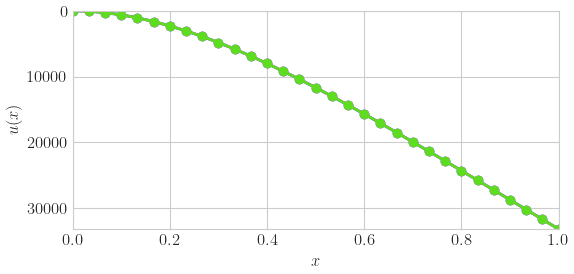

In [232]:
from matplotlib import pyplot
pyplot.style.use('../../../../qmcpy.mplstyle') #may need to be changed to find path to document in QMCSoftware folder
fig,ax = pyplot.subplots(figsize=(6,3))
ax.plot(x_values, solution,'-o')
ax.plot(x_values, data.comb_bound_low,'-o')
ax.plot(x_values, data.comb_bound_high,'-o')
ax.set_xlim([0,1]); ax.set_xlabel(r'$x$') #[0,len(solution)-1]
ax.set_ylim([max(solution), min(solution)]);  ax.set_ylabel(r'$u(x)$');

## Parallel Evaluation

QMCPy can automatically multi-threaded requests to the model by setting `parallel=p` where `p` is the number of processors used by [multiprocessing.pool.ThreadPool](https://docs.python.org/3/library/multiprocessing.html#multiprocessing.pool.ThreadPool). Setting `parallel=True` is equivalent to setting `paralle=os.cpu_count()`.

In [27]:
import os
print('Available CPUs: %d'%os.cpu_count())

Available CPUs: 8


In [234]:
integrand = qp.UMBridgeWrapper(distribution,model,umbridge_config,parallel=8,tf_input_to_umbridge_input = E_generator_2)
solution,data = qp.CubQMCNetG(integrand,abs_tol=10).integrate()
data

LDTransformData (AccumulateData Object)
    solution        [    0.       72.68    281.244 ... 30198.851 31680.562 33162.467]
    comb_bound_low  [    0.       72.68    281.243 ... 30198.784 31680.492 33162.394]
    comb_bound_high [    0.       72.68    281.245 ... 30198.917 31680.631 33162.54 ]
    comb_flags      [ True  True  True ...  True  True  True]
    n_total         2^(10)
    n               [1024. 1024. 1024. ... 1024. 1024. 1024.]
    time_integrate  10.082
CubQMCNetG (StoppingCriterion Object)
    abs_tol         10
    rel_tol         0
    n_init          2^(10)
    n_max           2^(35)
UMBridgeWrapper (Integrand Object)
Uniform (TrueMeasure Object)
    lower_bound     1
    upper_bound     1.100
DigitalNetB2 (DiscreteDistribution Object)
    d               3
    dvec            [0 1 2]
    randomize       LMS_DS
    graycode        0
    entropy         7
    spawn_key       ()

## Shut Down Docker Image

In [239]:
!docker rm -f muqbp_new

muqbp_new
